### Definir como escolher os ativos:

Para definir quais ativos entram no portfólio, algumas abordagens possíveis são:

- Alta liquidez: Selecionar ativos com maior volume de negociação.
- Baixo Beta: Escolher ativos menos voláteis (se for um portfólio conservador).
- Alto Sharpe Ratio: Melhor retorno ajustado ao risco.
- P/E Ratio (Preço/Lucro): Avalia se a ação está sub ou sobrevalorizada.
- Momentum: Ativos com bom desempenho recente tendem a continuar performando bem.

#### estracao

In [ ]:
from investpy import get_stocks_list
import yfinance as yf
import time
from tqdm import tqdm  

# Obtém a lista de ações brasileiras
br_tickers = get_stocks_list(country="brazil")

# Adiciona o sufixo .SA para buscar no yfinance
br_tickers_yf = [ticker + ".SA" for ticker in br_tickers]

# Função para verificar quais tickers existem no yfinance
def check_tickers(ticker_list):
    available_tickers = []
    
    for ticker in tqdm(ticker_list, desc="Verificando tickers"):
        try:
            stock = yf.Ticker(ticker)
            hist = stock.history(period="1d")
            if not hist.empty:
                available_tickers.append(ticker)
        except Exception as e:
            print(f"Erro ao verificar {ticker}: {e}")
        time.sleep(0.5)  # Evitar bloqueios por excesso de requisições
    
    return available_tickers

# Testar quais tickers estão disponíveis
valid_tickers = check_tickers(br_tickers_yf)

# Salvar os tickers válidos em um arquivo .txt
with open("valid_tickers.txt", "w") as file:
    for ticker in valid_tickers:
        file.write(ticker + "\n")

print("\nTickers disponíveis salvos em 'valid_tickers.txt'.")

# Para ler os tickers depois:
with open("valid_tickers.txt", "r") as file:
    saved_tickers = [line.strip() for line in file.readlines()]

print("\nTickers lidos do arquivo:", saved_tickers)

In [13]:
# Ler o arquivo original
with open("valid_tickers.txt", "r") as file:
    tickers = file.readlines()

# Dividir os tickers em 4 partes iguais
num_parts = 4
chunk_size = len(tickers) // num_parts
chunks = [tickers[i:i + chunk_size] for i in range(0, len(tickers), chunk_size)]

# Garantir que todos os tickers sejam distribuídos
if len(chunks) > num_parts:
    chunks[-2].extend(chunks[-1])
    chunks = chunks[:-1]

# Salvar cada parte em um arquivo separado
for i, chunk in enumerate(chunks):
    with open(f"valid_tickers_part_{i + 1}.txt", "w") as file:
        file.writelines(chunk)

#### calculo das metricas

In [ ]:
import yfinance as yf
import numpy as np
import time
import pandas as pd
from tqdm import tqdm  # Barra de progresso

# Para ler os tickers depois:
with open("valid_tickers_part_4.txt", "r") as file:
    tickers = [line.strip() for line in file.readlines()]

# Lista de ativos
tickers_ = ['PETR4.SA', 'MGLU3.SA', 'BBDC4.SA', 'VALE3.SA',
           'WEGE3.SA', 'BPAC11.SA', 'KNRI11.SA', 'AAPL34.SA',
           'COCA34.SA', 'EQTL3.SA', 'RENT3.SA', 'B3SA3.SA']

# Função para verificar a liquidez
def get_liquidity(tickers):
    liquidity = {}
    for ticker in tqdm(tickers, desc="Verificando liquidez"):
        try:
            stock = yf.Ticker(ticker)
            data = stock.history(period="6mo")
            avg_volume = data['Volume'].mean()
            liquidity[ticker] = avg_volume if avg_volume is not None else 0
            time.sleep(0.5)  # Evita bloqueio
        except Exception as e:
            print(f"Erro ao processar {ticker}: {e}")
            liquidity[ticker] = 0  # Define como zero caso falhe
    return liquidity

# Funções de análise de cada métrica
def get_beta(ticker, market_ticker='^BVSP'):
    try:
        stock = yf.Ticker(ticker)
        market = yf.Ticker(market_ticker)
        
        stock_data = stock.history(period="6mo")['Close']
        market_data = market.history(period="6mo")['Close']
        
        # Verificar se os dados estão vazios
        if stock_data.empty or market_data.empty:
            print(f"Dados vazios para {ticker} ou {market_ticker}")
            return None
        
        # Alinhar os índices de datas
        aligned_data = pd.DataFrame({
            'stock': stock_data,
            'market': market_data
        }).dropna()  # Remove datas onde qualquer um dos dois está ausente
        
        # Calcular retornos
        stock_returns = aligned_data['stock'].pct_change().dropna()
        market_returns = aligned_data['market'].pct_change().dropna()
        
        # Verificar se os retornos estão vazios
        if stock_returns.empty or market_returns.empty:
            print(f"Retornos vazios para {ticker} ou {market_ticker}")
            return None
        
        # Calcular Beta
        covariance = np.cov(stock_returns, market_returns)[0][1]
        market_variance = np.var(market_returns)
        beta = covariance / market_variance
        return beta
    except Exception as e:
        print(f"Erro ao calcular beta para {ticker}: {e}")
        return None

def get_sharpe_ratio(ticker, risk_free_rate=0.06):
    try:
        stock = yf.Ticker(ticker)
        data = stock.history(period="6mo")['Close']
        daily_returns = data.pct_change().dropna()
        
        avg_return = daily_returns.mean()
        volatility = daily_returns.std()
        
        sharpe_ratio = (avg_return - risk_free_rate / 252) / volatility
        return sharpe_ratio
    except Exception as e:
        print(f"Erro ao calcular Sharpe Ratio para {ticker}: {e}")
        return None

def get_pe_ratio(ticker):
    try:
        stock = yf.Ticker(ticker)
        pe_ratio = stock.info.get('trailingPE', None)
        return pe_ratio
    except Exception as e:
        print(f"Erro ao obter P/E Ratio para {ticker}: {e}")
        return None

def get_momentum(ticker, period='6mo'):
    try:
        stock = yf.Ticker(ticker)
        data = stock.history(period=period)['Close']
        return data.pct_change().sum()
    except Exception as e:
        print(f"Erro ao calcular Momentum para {ticker}: {e}")
        return None

# Função para dividir os tickers em lotes
def process_in_batches(tickers, batch_size=100):
    selected_assets = []
    # Dividindo os tickers em lotes
    for i in range(0, len(tickers), batch_size):
        batch = tickers[i:i+batch_size]
        print(f"\nProcessando lote {i//batch_size + 1} de {len(tickers)//batch_size + 1}...\n")

        liquidity = get_liquidity(batch)  # Verificando liquidez para o lote

        for ticker in tqdm(batch, desc="Analisando ativos", position=0):
            try:
                beta = get_beta(ticker)
                sharpe = get_sharpe_ratio(ticker)
                pe_ratio = get_pe_ratio(ticker)
                momentum = get_momentum(ticker)

                print(f"Analisando {ticker}: Beta={beta}, Sharpe={sharpe}, PE={pe_ratio}, Momentum={momentum}")

                selected_assets.append({
                        'ticker': ticker,
                        'liquidity': liquidity[ticker],
                        'beta': beta,
                        'sharpe': sharpe,
                        'pe_ratio': pe_ratio,
                        'momentum': momentum
                    })
                
                time.sleep(0.5)  # Adiciona pausa entre requisições para evitar bloqueios

            except Exception as e:
                print(f"Erro ao processar {ticker}: {e}")
        
        print("Aguardando para evitar limitação")
        time.sleep(5)  # Pausa entre os lotes para evitar bloqueios

    return selected_assets

# Executar a seleção em lotes
selected_assets = process_in_batches(tickers)

# Criar DataFrame e salvar em CSV para análise futura
df = pd.DataFrame(selected_assets)
df.to_csv("selected_assets_4.csv", index=False)
print("\nAtivos selecionados salvos em 'selected_assets.csv'")


🔄 Processando lote 1 de 2...



Analisando ativos:   0%|          | 0/100 [00:00<?, ?it/s]

Analisando GOGL35.SA: Beta=-0.12192898143678514, Sharpe=0.035197593070069005, PE=21.35, Momentum=0.10975610133893299


Analisando ativos:   1%|          | 1/100 [00:00<01:20,  1.23it/s]

Analisando MACY34.SA: Beta=-0.15378959564303268, Sharpe=-0.0006919794575450081, PE=6.8, Momentum=0.02669633831404905


Analisando ativos:   2%|▏         | 2/100 [00:01<01:14,  1.32it/s]

Analisando MDTC34.SA: Beta=0.044685694630092074, Sharpe=0.019997184132556318, PE=27.703545, Momentum=0.06563213720923422


Analisando ativos:   3%|▎         | 3/100 [00:02<01:13,  1.32it/s]

Analisando RIGG34.SA: Beta=0.5210159362796416, Sharpe=-0.05293316867596168, PE=None, Momentum=-0.2111680066354965


Analisando ativos:   4%|▍         | 4/100 [00:03<01:11,  1.33it/s]

Analisando ROST34.SA: Beta=-0.2864770300738784, Sharpe=-0.08047415332232327, PE=19.765625, Momentum=-0.13409608524204952


Analisando ativos:   5%|▌         | 5/100 [00:03<01:14,  1.27it/s]

Analisando SCHW34.SA: Beta=0.13464646014731665, Sharpe=0.0987363568652481, PE=27.051888, Momentum=0.27647319013443106


Analisando ativos:   6%|▌         | 6/100 [00:04<01:12,  1.29it/s]

Analisando SSFO34.SA: Beta=-0.27011024137065165, Sharpe=0.04059018429637118, PE=45.7439, Momentum=0.1488153299960382


Analisando ativos:   7%|▋         | 7/100 [00:05<01:10,  1.31it/s]

Analisando TMOS34.SA: Beta=-0.4040084071600212, Sharpe=-0.04621380846815566, PE=31.779488, Momentum=-0.08701298746010655


Analisando ativos:   8%|▊         | 8/100 [00:06<01:11,  1.29it/s]

Analisando TRVC34.SA: Beta=0.3408156027170007, Sharpe=0.07679192457900134, PE=12.115486, Momentum=0.25986759872213017


Analisando ativos:   9%|▉         | 9/100 [00:06<01:09,  1.32it/s]

Analisando AALR3.SA: Beta=0.43514711119462923, Sharpe=-0.0298887956248302, PE=None, Momentum=-0.10084639072320267


Analisando ativos:  10%|█         | 10/100 [00:07<01:07,  1.34it/s]

Analisando BNFS11.SA: Beta=-0.016990122529790853, Sharpe=-0.25861574014565314, PE=None, Momentum=-0.43623043301123543


Analisando ativos:  11%|█         | 11/100 [00:08<01:06,  1.34it/s]

Analisando CBOP11.SA: Beta=-0.2375719104457485, Sharpe=-0.024387846994175594, PE=None, Momentum=-0.07414508667499053


Analisando ativos:  12%|█▏        | 12/100 [00:09<01:07,  1.31it/s]

Analisando CEBR3.SA: Beta=0.17544512008577634, Sharpe=-0.023413401882126057, PE=7.702128, Momentum=-0.016635150434133883


Analisando ativos:  13%|█▎        | 13/100 [00:09<01:05,  1.32it/s]

Analisando FIIB11.SA: Beta=0.049192285805165485, Sharpe=0.032381459058454576, PE=None, Momentum=0.06341152669468386


Analisando ativos:  14%|█▍        | 14/100 [00:10<01:05,  1.32it/s]

Analisando FIVN11.SA: Beta=0.31761261983980593, Sharpe=-0.07334674500626592, PE=None, Momentum=-0.42647494898249216


Analisando ativos:  15%|█▌        | 15/100 [00:11<01:03,  1.33it/s]

Analisando FMOF11.SA: Beta=0.4688085179865279, Sharpe=0.01401989554316074, PE=None, Momentum=0.09241772396282322


Analisando ativos:  16%|█▌        | 16/100 [00:12<01:03,  1.33it/s]

Analisando FNOR11.SA: Beta=-0.2953357536276148, Sharpe=0.05674206611751792, PE=None, Momentum=0.3223489668802937


Analisando ativos:  17%|█▋        | 17/100 [00:12<01:01,  1.35it/s]

Analisando PABY11.SA: Beta=-0.3169210734775935, Sharpe=-0.05351942382802624, PE=None, Momentum=-0.2033043041364595


Analisando ativos:  18%|█▊        | 18/100 [00:13<01:00,  1.36it/s]

Analisando PATI4.SA: Beta=-0.0005938942430731048, Sharpe=0.06532273919320059, PE=10.670732, Momentum=0.22435668898186734


Analisando ativos:  19%|█▉        | 19/100 [00:14<00:59,  1.35it/s]

Analisando PLRI11.SA: Beta=-1.2096944628649824, Sharpe=0.05671534731076169, PE=None, Momentum=0.47983159944832665


Analisando ativos:  20%|██        | 20/100 [00:15<00:58,  1.36it/s]

Analisando PORD11.SA: Beta=0.17516859064658166, Sharpe=-0.0009066416554988668, PE=0.99385744, Momentum=0.02731789087139791


Analisando ativos:  21%|██        | 21/100 [00:15<00:59,  1.33it/s]

Analisando RBDS11.SA: Beta=-0.6250752552219339, Sharpe=0.0013252857840873485, PE=None, Momentum=0.03875240832944837


Analisando ativos:  22%|██▏       | 22/100 [00:16<00:58,  1.34it/s]

Analisando RPAD3.SA: Beta=0.20454381780627987, Sharpe=-0.16804498556893185, PE=None, Momentum=-0.8289605105238002


Analisando ativos:  23%|██▎       | 23/100 [00:17<00:57,  1.34it/s]

Analisando SCPF11.SA: Beta=0.1712037710584453, Sharpe=-0.1218785546088146, PE=None, Momentum=-0.3118498796715986


Analisando ativos:  24%|██▍       | 24/100 [00:18<00:56,  1.35it/s]

Analisando MOVI3.SA: Beta=2.9020548007791067, Sharpe=-0.03465345169958993, PE=9.729167, Momentum=-0.15892390037176807


Analisando ativos:  25%|██▌       | 25/100 [00:18<00:55,  1.35it/s]

Analisando BPAC11.SA: Beta=1.3098369420656464, Sharpe=0.03662370896834593, PE=57.361565, Momentum=0.11132703708382996


Analisando ativos:  26%|██▌       | 26/100 [00:19<00:54,  1.35it/s]

Analisando PPLA11.SA: Beta=1.0065008125036983, Sharpe=-0.10554504839753158, PE=242.00002, Momentum=-0.6130441813877413


Analisando ativos:  27%|██▋       | 27/100 [00:20<00:53,  1.36it/s]

Analisando AALL34.SA: Beta=-0.11485490175853678, Sharpe=0.03851945665585844, PE=9.613636, Momentum=0.172099830712374


Analisando ativos:  28%|██▊       | 28/100 [00:21<00:52,  1.36it/s]

Analisando GMCO34.SA: Beta=-0.3911605494769291, Sharpe=0.040820957719428765, PE=8.155973, Momentum=0.17532663240058932


Analisando ativos:  29%|██▉       | 29/100 [00:21<00:52,  1.36it/s]

Analisando UPAC34.SA: Beta=-0.20296252006889454, Sharpe=-0.024432827303091157, PE=21.237913, Momentum=-0.0167715663644582


Analisando ativos:  30%|███       | 30/100 [00:22<00:52,  1.34it/s]

Analisando RNEW3.SA: Beta=0.44604658476487513, Sharpe=0.022229878050327508, PE=5.5555553, Momentum=0.12083836479424803


Analisando ativos:  31%|███       | 31/100 [00:23<00:50,  1.35it/s]

Analisando RNEW4.SA: Beta=0.5162928311580116, Sharpe=0.017318533145642533, PE=5.388889, Momentum=0.09966506414851439


Analisando ativos:  32%|███▏      | 32/100 [00:23<00:50,  1.36it/s]

Analisando AZUL4.SA: Beta=1.7744604814429152, Sharpe=-0.050087779117055135, PE=None, Momentum=-0.23101038545454


Analisando ativos:  33%|███▎      | 33/100 [00:24<00:49,  1.35it/s]

Analisando KNIP11.SA: Beta=-0.013987136476816615, Sharpe=-0.0064657144047406, PE=9.913943, Momentum=0.023202556252644113


Analisando ativos:  34%|███▍      | 34/100 [00:25<00:48,  1.35it/s]

Analisando TEND3.SA: Beta=1.6860396148274819, Sharpe=0.03130235733654194, PE=16.698795, Momentum=0.1406710172607425


Analisando ativos:  35%|███▌      | 35/100 [00:26<00:49,  1.31it/s]

Analisando TSLA34.SA: Beta=-0.1123764688791943, Sharpe=0.04309011626300398, PE=138.88889, Momentum=0.2765587346313598


Analisando ativos:  36%|███▌      | 36/100 [00:26<00:47,  1.34it/s]

Analisando CRFB3.SA: Beta=1.6368476411099817, Sharpe=-0.03534352054870004, PE=8.951807, Momentum=-0.11702848072369998


Analisando ativos:  37%|███▋      | 37/100 [00:27<00:46,  1.34it/s]

Analisando IRBR3.SA: Beta=1.535995143674284, Sharpe=0.040142361332263225, PE=5.293401, Momentum=0.20154320746660537


Analisando ativos:  38%|███▊      | 38/100 [00:28<00:46,  1.32it/s]

Analisando GGRC11.SA: Beta=0.08149343821632804, Sharpe=-0.029464596684542453, PE=None, Momentum=-0.005709259011888346


Analisando ativos:  39%|███▉      | 39/100 [00:29<00:46,  1.32it/s]

Analisando GEPA3.SA: Beta=-0.28686017797257624, Sharpe=0.0677709216746537, PE=Infinity, Momentum=0.28919090699768457


Analisando ativos:  40%|████      | 40/100 [00:30<00:45,  1.31it/s]

Analisando CAML3.SA: Beta=1.3622249155720867, Sharpe=-0.2656285138409579, PE=3.8484848, Momentum=-0.7953038587763713


Analisando ativos:  41%|████      | 41/100 [00:30<00:44,  1.32it/s]

Analisando VISC11.SA: Beta=-0.0460220468475525, Sharpe=0.00344280777061313, PE=4.9951806, Momentum=0.03476658044682468


Analisando ativos:  42%|████▏     | 42/100 [00:31<00:43,  1.34it/s]

Analisando SUZB3.SA: Beta=0.1081610744246645, Sharpe=0.02175838439517346, PE=None, Momentum=0.06327543250165502


Analisando ativos:  43%|████▎     | 43/100 [00:32<00:45,  1.27it/s]

Analisando SAPR11.SA: Beta=0.4143136543645159, Sharpe=-0.048035654057721, PE=34.36341, Momentum=-0.06577070762711434


Analisando ativos:  44%|████▍     | 44/100 [00:33<00:44,  1.26it/s]

Analisando NEOE3.SA: Beta=0.7915807477761498, Sharpe=0.036111230790408275, PE=6.966555, Momentum=0.0901130466492216


Analisando ativos:  45%|████▌     | 45/100 [00:33<00:42,  1.29it/s]

Analisando ALZR11.SA: Beta=-0.00021418919925968933, Sharpe=-0.02218535292170672, PE=13.683127, Momentum=0.005604585232376724


Analisando ativos:  46%|████▌     | 46/100 [00:34<00:41,  1.30it/s]

Analisando UBSG34.SA: Beta=-0.021743738982584762, Sharpe=0.06016183539412204, PE=21.993048, Momentum=0.15854332111094538


Analisando ativos:  47%|████▋     | 47/100 [00:35<00:40,  1.30it/s]

Analisando TXRX4.SA: Beta=0.4075564371342235, Sharpe=-0.07493011419857135, PE=0.3744856, Momentum=-0.215268688172651


Analisando ativos:  48%|████▊     | 48/100 [00:36<00:40,  1.30it/s]

Analisando OUJP11.SA: Beta=-0.03944365721909184, Sharpe=0.03444254182339162, PE=None, Momentum=0.07955781185852084


Analisando ativos:  49%|████▉     | 49/100 [00:37<00:39,  1.29it/s]

Analisando BCIA11.SA: Beta=0.0734473157381374, Sharpe=-0.04744002280704661, PE=None, Momentum=-0.04976807150412155


Analisando ativos:  50%|█████     | 50/100 [00:37<00:38,  1.31it/s]

Analisando BOXP34.SA: Beta=0.038419738014249125, Sharpe=-0.03736476977246899, PE=794.4, Momentum=-0.07491969471183468


Analisando ativos:  51%|█████     | 51/100 [00:38<00:36,  1.33it/s]

Analisando GPRO34.SA: Beta=0.37513586528533127, Sharpe=-0.06591471231759703, PE=None, Momentum=-0.30784551085323875


Analisando ativos:  52%|█████▏    | 52/100 [00:39<00:35,  1.35it/s]

Analisando HFOF11.SA: Beta=0.11564512026707274, Sharpe=-0.15270624610978892, PE=6.4430084, Momentum=-0.1467533738832758


Analisando ativos:  53%|█████▎    | 53/100 [00:39<00:35,  1.32it/s]

Analisando RBRF11.SA: Beta=0.2828328590571197, Sharpe=-0.017779288298092024, PE=5.2338705, Momentum=0.0025082306612721483


Analisando ativos:  54%|█████▍    | 54/100 [00:40<00:35,  1.30it/s]

Analisando HAPV3.SA: Beta=2.057196769387504, Sharpe=-0.15159615903338314, PE=None, Momentum=-0.6342283089881267


Analisando ativos:  55%|█████▌    | 55/100 [00:41<00:33,  1.33it/s]

Analisando GPIV33.SA: Beta=-0.8764661304443063, Sharpe=0.0009257872043286053, PE=1.0506667, Momentum=0.03335898278839633


Analisando ativos:  56%|█████▌    | 56/100 [00:42<00:32,  1.35it/s]

Analisando IRDM11.SA: Beta=0.12860119558945113, Sharpe=0.053618212353196006, PE=16.79753, Momentum=0.0977169155281491


Analisando ativos:  57%|█████▋    | 57/100 [00:42<00:31,  1.36it/s]

Analisando TAEE4.SA: Beta=0.5147969815465383, Sharpe=-0.01109137372932399, PE=6.9512196, Momentum=0.01686880349955333


Analisando ativos:  58%|█████▊    | 58/100 [00:43<00:31,  1.35it/s]

Analisando XPLG11.SA: Beta=-0.012456405697717776, Sharpe=-0.022255002938340707, PE=13.25457, Momentum=-0.0009231082736795848


Analisando ativos:  59%|█████▉    | 59/100 [00:44<00:30,  1.33it/s]

Analisando RBRR11.SA: Beta=0.11803775318940139, Sharpe=-0.007028988589631555, PE=None, Momentum=0.01856709490634989


Analisando ativos:  60%|██████    | 60/100 [00:45<00:30,  1.32it/s]

Analisando WPLZ11.SA: Beta=0.14599036572327656, Sharpe=0.01863188911062089, PE=None, Momentum=0.10470652755496923


Analisando ativos:  61%|██████    | 61/100 [00:46<00:29,  1.30it/s]

Analisando TGAR11.SA: Beta=0.17837133796645668, Sharpe=-0.08631528435277784, PE=None, Momentum=-0.14394439267316717


Analisando ativos:  62%|██████▏   | 62/100 [00:46<00:28,  1.32it/s]

Analisando HGRU11.SA: Beta=0.13338907268894806, Sharpe=-0.008180585467205011, PE=7.273913, Momentum=0.01921384623701461


Analisando ativos:  63%|██████▎   | 63/100 [00:47<00:27,  1.33it/s]

Analisando ALUP3.SA: Beta=0.8160574139150613, Sharpe=-0.029468215641911467, PE=8.568965, Momentum=-0.027741277437050016


Analisando ativos:  64%|██████▍   | 64/100 [00:48<00:26,  1.34it/s]

Analisando ALUP4.SA: Beta=0.759137016022308, Sharpe=-0.022895500228375006, PE=8.431034, Momentum=-0.009989980213241711


Analisando ativos:  65%|██████▌   | 65/100 [00:48<00:25,  1.35it/s]

Analisando LOGG3.SA: Beta=1.0120912175778147, Sharpe=-0.042452547736502304, PE=4.9861116, Momentum=-0.09491451813825647


Analisando ativos:  66%|██████▌   | 66/100 [00:49<00:25,  1.35it/s]

Analisando KNHY11.SA: Beta=0.06054962317053019, Sharpe=-0.023607579594037108, PE=10.295337, Momentum=0.002822973750484681


Analisando ativos:  67%|██████▋   | 67/100 [00:50<00:24,  1.36it/s]

Analisando FVPQ11.SA: Beta=0.22370633256653707, Sharpe=-0.08126035950807703, PE=None, Momentum=-0.16740401084474255


Analisando ativos:  68%|██████▊   | 68/100 [00:51<00:23,  1.35it/s]

Analisando CARE11.SA: Beta=0.0380999964609556, Sharpe=-0.027964028751457825, PE=0.011368989, Momentum=-0.07346584794262068


Analisando ativos:  69%|██████▉   | 69/100 [00:51<00:23,  1.34it/s]

Analisando TAEE3.SA: Beta=0.5284690052402324, Sharpe=-0.006553534410082895, PE=6.9329267, Momentum=0.02127173921825265


Analisando ativos:  70%|███████   | 70/100 [00:52<00:22,  1.33it/s]

Analisando XPIN11.SA: Beta=-0.050760446381467234, Sharpe=-0.007176503151297856, PE=7.0325866, Momentum=0.019054028778013543


Analisando ativos:  71%|███████   | 71/100 [00:53<00:21,  1.32it/s]

Analisando VSHO11.SA: Beta=-0.023036118072318864, Sharpe=-0.02388410684569573, PE=6.0640216, Momentum=-0.013471713989791856


Analisando ativos:  72%|███████▏  | 72/100 [00:54<00:21,  1.31it/s]

Analisando AZEV3.SA: Beta=-0.6361547860340053, Sharpe=0.006179445508705684, PE=None, Momentum=0.08697062983676485


Analisando ativos:  73%|███████▎  | 73/100 [00:54<00:20,  1.33it/s]

Analisando BPAC3.SA: Beta=1.146185121624053, Sharpe=0.0613789697232792, PE=11.294478, Momentum=0.2087864248850817


Analisando ativos:  74%|███████▍  | 74/100 [00:55<00:19,  1.31it/s]

Analisando HAGA3.SA: Beta=0.6660216633613871, Sharpe=-0.023175504725173716, PE=6.138889, Momentum=-0.06658372084973219


Analisando ativos:  75%|███████▌  | 75/100 [00:56<00:19,  1.30it/s]

Analisando PATI3.SA: Beta=-1.0386869172374154, Sharpe=0.03350794668613487, PE=8.353659, Momentum=0.2287806883925022


Analisando ativos:  76%|███████▌  | 76/100 [00:57<00:18,  1.30it/s]

Analisando BPAC5.SA: Beta=1.278382408469666, Sharpe=0.0036676012422786866, PE=5.141104, Momentum=0.04031529749131102


Analisando ativos:  77%|███████▋  | 77/100 [00:58<00:17,  1.30it/s]

Analisando LUXM4.SA: Beta=0.2392550161780887, Sharpe=-0.047969435511203674, PE=16.764706, Momentum=-0.12352692520059882


Analisando ativos:  78%|███████▊  | 78/100 [00:58<00:17,  1.29it/s]

Analisando MERC4.SA: Beta=-0.1728586382586872, Sharpe=0.0022821312306423535, PE=15.655738, Momentum=0.035381218433009676


Analisando ativos:  79%|███████▉  | 79/100 [00:59<00:16,  1.29it/s]

Analisando RSUL4.SA: Beta=0.2106936897996038, Sharpe=0.08010058444351692, PE=7.315408, Momentum=0.17038166992311832


Analisando ativos:  80%|████████  | 80/100 [01:00<00:15,  1.31it/s]

Analisando PATC11.SA: Beta=0.10540537778411013, Sharpe=0.0376075473351341, PE=None, Momentum=0.06786970116188062


Analisando ativos:  81%|████████  | 81/100 [01:01<00:14,  1.30it/s]

Analisando BBDC3.SA: Beta=1.2620346514797216, Sharpe=-0.04153834902064362, PE=8.846154, Momentum=-0.04953036812671374


Analisando ativos:  82%|████████▏ | 82/100 [01:01<00:13,  1.30it/s]

Analisando VGIR11.SA: Beta=-0.017976519200970757, Sharpe=0.010914562142208407, PE=None, Momentum=0.04149907110997164


Analisando ativos:  83%|████████▎ | 83/100 [01:02<00:13,  1.31it/s]

Analisando VILG11.SA: Beta=0.0761190317895171, Sharpe=0.0010750799453376001, PE=8.361876, Momentum=0.030503310637189585


Analisando ativos:  84%|████████▍ | 84/100 [01:03<00:12,  1.32it/s]

Analisando VAMO3.SA: Beta=2.452298292717412, Sharpe=-0.06445368036694216, PE=6.703125, Momentum=-0.2838197671435033


Analisando ativos:  85%|████████▌ | 85/100 [01:04<00:11,  1.32it/s]

Analisando MELI34.SA: Beta=-0.03192265535016034, Sharpe=0.02392526229575014, PE=57.52809, Momentum=0.10559237625006768


Analisando ativos:  86%|████████▌ | 86/100 [01:04<00:10,  1.31it/s]

Analisando MOAR3.SA: Beta=-0.33750493782939134, Sharpe=-0.04015535241258204, PE=50.50505, Momentum=-0.11933267312928741


Analisando ativos:  87%|████████▋ | 87/100 [01:05<00:09,  1.31it/s]

Analisando RBVA11.SA: Beta=0.01322699847215181, Sharpe=-0.1431379192111955, PE=4.46482, Momentum=-0.18039096154984147


Analisando ativos:  88%|████████▊ | 88/100 [01:06<00:09,  1.29it/s]

Analisando MRSA3B.SA: Beta=-0.02205916138462089, Sharpe=-0.0025345313378124304, PE=7.730673, Momentum=0.022672414678171715


Analisando ativos:  89%|████████▉ | 89/100 [01:07<00:08,  1.31it/s]

Analisando VTLT11.SA: Beta=-0.08727492469364094, Sharpe=-0.04242649747685389, PE=3.7782743, Momentum=-0.03227914804020382


Analisando ativos:  90%|█████████ | 90/100 [01:08<00:07,  1.31it/s]

Analisando GTWR11.SA: Beta=0.035943875818824654, Sharpe=-0.04060829162605614, PE=4.594203, Momentum=-0.019361088841909013


Analisando ativos:  91%|█████████ | 91/100 [01:08<00:06,  1.33it/s]

Analisando HCTR11.SA: Beta=-0.23254286385863465, Sharpe=-0.06445625444362736, PE=3.539823, Momentum=-0.22409228682949645


Analisando ativos:  92%|█████████▏| 92/100 [01:09<00:06,  1.31it/s]

Analisando HSML11.SA: Beta=0.1567973535388862, Sharpe=-0.0485090436657322, PE=3.5452151, Momentum=-0.04451751332010745


Analisando ativos:  93%|█████████▎| 93/100 [01:10<00:05,  1.33it/s]

Analisando HABT11.SA: Beta=0.09598082402057627, Sharpe=-0.01321766227632433, PE=None, Momentum=0.007338623228831831


Analisando ativos:  94%|█████████▍| 94/100 [01:11<00:04,  1.33it/s]

Analisando RECT11.SA: Beta=0.08766823469823766, Sharpe=0.04173133973347187, PE=0.65652007, Momentum=0.1158111189755534


Analisando ativos:  95%|█████████▌| 95/100 [01:11<00:03,  1.35it/s]

Analisando BARI11.SA: Beta=0.07747493294088044, Sharpe=0.023690181721074205, PE=7.256134, Momentum=0.07066902002660791


Analisando ativos:  96%|█████████▌| 96/100 [01:12<00:02,  1.34it/s]/tmp/ipykernel_2560/132136646.py:73: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  daily_returns = data.pct_change().dropna()
/tmp/ipykernel_2560/132136646.py:97: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  return data.pct_change().sum()


Analisando ERPA11.SA: Beta=-0.04151189573553527, Sharpe=-0.006238950713189621, PE=10.1804285, Momentum=0.005189710488540777


Analisando ativos:  97%|█████████▋| 97/100 [01:13<00:02,  1.29it/s]

Analisando FISC11.SA: Beta=-0.2501037164217203, Sharpe=0.00858648276482279, PE=6.572295, Momentum=0.08609652132703782


Analisando ativos:  98%|█████████▊| 98/100 [01:14<00:01,  1.31it/s]

Analisando HGFF11.SA: Beta=0.1339193099870008, Sharpe=-0.05889191855832951, PE=4.577252, Momentum=-0.05965484433960688


Analisando ativos:  99%|█████████▉| 99/100 [01:14<00:00,  1.33it/s]

Analisando HUSC11.SA: Beta=-0.8276257422307893, Sharpe=-0.01758909868350357, PE=4.416821, Momentum=-0.04004975524190035


Analisando ativos: 100%|██████████| 100/100 [01:15<00:00,  1.32it/s]


⏳ Aguardando para evitar limitação...

🔄 Processando lote 2 de 2...



Analisando ativos:   0%|          | 0/11 [00:00<?, ?it/s]

Analisando NVHO11.SA: Beta=0.04669356281206364, Sharpe=0.01265258329579894, PE=None, Momentum=0.08805605954084816


Analisando ativos:   9%|▉         | 1/11 [00:00<00:07,  1.38it/s]

Analisando RBFF11.SA: Beta=0.05199695164872621, Sharpe=-0.05089513541190014, PE=8.11199, Momentum=-0.08596564512216553


Analisando ativos:  18%|█▊        | 2/11 [00:01<00:06,  1.41it/s]

Analisando RBRP11.SA: Beta=0.3460934498459255, Sharpe=-0.06896417961421408, PE=None, Momentum=-0.10610287366680138


Analisando ativos:  27%|██▋       | 3/11 [00:02<00:05,  1.40it/s]

Analisando RBRY11.SA: Beta=0.03464176541933067, Sharpe=0.005755284909264097, PE=None, Momentum=0.03706255710425388


Analisando ativos:  36%|███▋      | 4/11 [00:03<00:05,  1.29it/s]

Analisando RCFA11.SA: Beta=0.21438066161919964, Sharpe=-0.07375703740339357, PE=0.07474748, Momentum=-0.2840735484544231


Analisando ativos:  45%|████▌     | 5/11 [00:03<00:04,  1.33it/s]

Analisando SADI11.SA: Beta=0.12984194616106517, Sharpe=0.08143500517286845, PE=7.4322042, Momentum=0.147750582852626


Analisando ativos:  55%|█████▍    | 6/11 [00:04<00:03,  1.34it/s]

Analisando VIVA3.SA: Beta=1.6916153949938961, Sharpe=-0.11569686348239346, PE=6.7805758, Momentum=-0.3372276159936807


Analisando ativos:  64%|██████▎   | 7/11 [00:05<00:02,  1.36it/s]

Analisando CEAB3.SA: Beta=2.3010763837588195, Sharpe=0.02236475391868671, PE=7.0272107, Momentum=0.13510554491787308


Analisando ativos:  73%|███████▎  | 8/11 [00:05<00:02,  1.37it/s]

Analisando BMGB4.SA: Beta=0.7547149740560178, Sharpe=0.010429104309356922, PE=8.72093, Momentum=0.04963722480325028


Analisando ativos:  82%|████████▏ | 9/11 [00:06<00:01,  1.38it/s]

Analisando CVBI11.SA: Beta=-0.14662908943704073, Sharpe=-0.015800334164643753, PE=5.7934628, Momentum=0.0003231670740223569


Analisando ativos:  91%|█████████ | 10/11 [00:07<00:00,  1.39it/s]

Analisando HRDF11.SA: Beta=-0.28465302799214376, Sharpe=0.0009145512664642701, PE=1.6483516, Momentum=0.032288177235818116


Analisando ativos: 100%|██████████| 11/11 [00:08<00:00,  1.37it/s]


⏳ Aguardando para evitar limitação...

Ativos selecionados salvos em 'selected_assets.csv'


#### metodos numericos

In [ ]:
import pandas as pd
import os

# Caminho para a pasta onde os arquivos estão localizados
caminho_pasta = "/workspaces/Case-H2/data/selected_assets"

# Listar todos os arquivos CSV na pasta
arquivos_csv = [os.path.join(caminho_pasta, arquivo) for arquivo in os.listdir(caminho_pasta) if arquivo.endswith(".csv")]

# Ler todos os arquivos CSV e concatená-los em um único DataFrame
dataframes = [pd.read_csv(arquivo) for arquivo in arquivos_csv]
df_completo = pd.concat(dataframes, ignore_index=True)

# Salvar o DataFrame combinado em um novo arquivo CSV, se necessário
df_completo.to_csv("/workspaces/Case-H2/data/selected_assets_combined.csv", index=False)

In [11]:
import pandas as pd
import numpy as np

# Ler e limpar dados
df = (pd.read_csv("/workspaces/Case-H2/data/selected_assets/selected_assets_combined.csv")
      .drop_duplicates(subset=['ticker'], keep='first')
      .replace([np.inf, -np.inf], np.nan).dropna())

# Definição dos pesos
pesos = {
    "sharpe": 0.30,
    "momentum": 0.25,
    "liquidity": 0.20,
    "beta": 0.15,
    "pe_ratio": 0.10
}

# Normalização das métricas
for col in ["sharpe", "momentum", "liquidity"]:
    df[col] = (df[col] - df[col].min()) / (df[col].max() - df[col].min())

# Invertendo a normalização para beta e PE ratio (valores menores são melhores)
df["beta"] = 1 - (df["beta"] - df["beta"].min()) / (df["beta"].max() - df["beta"].min())
df["pe_ratio"] = 1 - (df["pe_ratio"] - df["pe_ratio"].min()) / (df["pe_ratio"].max() - df["pe_ratio"].min())

# Remover linhas onde os valores de determinadas colunas sejam exatamente 0.000000
df = df.loc[
    (df["liquidity"] != 0.000000) &
    (df["beta"] != 0.000000) &
    (df["sharpe"] != 0.000000) &
    (df["pe_ratio"] != 0.000000) &
    (df["momentum"] != 0.000000)
]

# Aplicando os pesos
df["score"] = (
    df["sharpe"] * pesos["sharpe"] +
    df["momentum"] * pesos["momentum"] +
    df["liquidity"] * pesos["liquidity"] +
    df["beta"] * pesos["beta"] +
    df["pe_ratio"] * pesos["pe_ratio"]
)

# Ordenando os ativos pelo score final
df = df.sort_values(by="score", ascending=False)

# Exibir resultado
# print(df[["ticker", "score"]])
df = df.head(10)
df

,ticker,liquidity,beta,sharpe,pe_ratio,momentum,score
90,PDGR3.SA,1.158243e-02,1.000000,0.810190,0.999999,1.000000,0.745373
20,B3SA3.SA,1.000000e+00,0.015885,0.696462,0.997379,0.013320,0.514389
141,COGN3.SA,8.313369e-01,0.006677,0.793096,0.999298,0.017265,0.509444
6,ABEV3.SA,6.579874e-01,0.024193,0.688057,0.997390,0.012775,0.444576
92,PETR4.SA,6.023297e-01,0.026494,0.688192,0.998040,0.012478,0.433821
9,BBDC4.SA,7.654667e-01,0.018579,0.506105,0.998293,0.010443,0.410152
185,FRAS3.SA,5.579535e-03,0.022744,1.000000,0.996503,0.015783,0.408123
84,MRFG3.SA,1.566266e-01,0.024327,0.869768,0.998343,0.017790,0.400187
156,ABCP11.SA,1.540147e-05,0.034130,0.947610,0.999174,0.015116,0.393102
321,ARNC34.SA,7.245728e-07,0.034358,0.936647,0.991448,0.016647,0.389454


### Fronteira eficiente Markovitz

Harry Markowitz criou em 1952 uma teoria que analise o risco de uma carteira de investimento.\
O objetivo do modelo é criar um portifólio que otimiza o risco-retorno dos investimentos disponíveis, escolhendo os ideias pra cada ativo na carteira.

In [21]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import datetime as dt
import pandas as pd
from scipy.optimize import minimize

# Como eles determinam o período de análise?
# 
inicio = "2024-09-01"
fim = "2025-02-28"
tickers = df['ticker'].tolist()
precos = yf.download(tickers, start=inicio, end=fim, progress=False)
if 'Adj Close' in precos.columns:
    precos = precos['Adj Close']
else:
    precos = precos['Close']

precos.head()

Ticker,ABCP11.SA,ABEV3.SA,ARNC34.SA,B3SA3.SA,BBDC4.SA,COGN3.SA,FRAS3.SA,MRFG3.SA,PDGR3.SA,PETR4.SA
Date,,,,,,,,,,
2024-09-02,60.964367,12.505385,538.441223,12.185976,14.844994,1.36,19.272867,11.945946,20.00,36.128258
2024-09-03,60.566395,12.437369,531.878174,11.911472,15.005986,1.35,19.391287,11.714568,20.00,35.692863
2024-09-04,60.693409,12.621986,531.878174,12.303620,15.120319,1.39,19.934046,12.588661,18.75,35.702129
2024-09-05,59.499519,12.602553,529.970215,12.342834,15.253706,1.41,19.943913,12.494397,20.00,35.479801
2024-09-06,60.270046,12.621986,532.087952,11.989902,14.958350,1.39,19.835361,12.408701,20.00,34.785030


In [22]:
retornos = precos.pct_change().dropna()
print(retornos.head())
media_retornos = retornos.mean()
print(media_retornos)
matriz_cov = retornos.cov()
print(matriz_cov)

Ticker      ABCP11.SA  ABEV3.SA  ARNC34.SA  B3SA3.SA  BBDC4.SA  COGN3.SA  \
Date                                                                       
2024-09-03  -0.006528 -0.005439  -0.012189 -0.022526  0.010845 -0.007353   
2024-09-04   0.002097  0.014844   0.000000  0.032922  0.007619  0.029630   
2024-09-05  -0.019671 -0.001540  -0.003587  0.003187  0.008822  0.014388   
2024-09-06   0.012950  0.001542   0.003996 -0.028594 -0.019363 -0.014184   
2024-09-09  -0.006041  0.009238   0.000000  0.005724  0.003185 -0.014388   

Ticker      FRAS3.SA  MRFG3.SA  PDGR3.SA  PETR4.SA  
Date                                                
2024-09-03  0.006144 -0.019369  0.000000 -0.012051  
2024-09-04  0.027990  0.074616 -0.062500  0.000260  
2024-09-05  0.000495 -0.007488  0.066667 -0.006227  
2024-09-06 -0.005443 -0.006859  0.000000 -0.019582  
2024-09-09 -0.014428 -0.008978  0.000000  0.010919  
Ticker
ABCP11.SA    0.001676
ABEV3.SA    -0.000071
ARNC34.SA    0.003202
B3SA3.SA    -0.000930
B

In [23]:
numero_carteiras = 100000
tabela_retornos_esperados = np.zeros(numero_carteiras)
tabela_volatilidade_esperadas = np.zeros(numero_carteiras)
tabela_shape = np.zeros(numero_carteiras)
tabela_pesos = np.zeros((numero_carteiras, len(tickers)))
print(f"Numero de carteiras: {numero_carteiras}, Tabela retorno esperados: {tabela_retornos_esperados.shape}, Tabela volatilidade esperada: {tabela_volatilidade_esperadas.shape}, Tabela shape: {tabela_shape.shape}, Tabela pesos: {tabela_pesos.shape}")

for i in range(numero_carteiras):
    pesos = np.random.random(len(tickers))
    pesos /= np.sum(pesos)
    tabela_pesos[i, :] = pesos
    
    tabela_retornos_esperados[i] = np.sum(pesos * media_retornos * 252)
    tabela_volatilidade_esperadas[i] = np.sqrt(np.dot(pesos.T, np.dot(matriz_cov * 252, pesos)))
    tabela_shape[i] = tabela_retornos_esperados[i] / tabela_volatilidade_esperadas[i]


Numero de carteiras: 100000, Tabela retorno esperados: (100000,), Tabela volatilidade esperada: (100000,), Tabela shape: (100000,), Tabela pesos: (100000, 10)


In [24]:
indice_do_shaper_maximo = tabela_shape.argmax()
tabela_pesos[indice_do_shaper_maximo]

array([3.09888993e-01, 7.15811551e-05, 2.34338870e-01, 3.71629187e-02,
       7.08517753e-03, 3.84824123e-02, 1.99442176e-01, 7.71972853e-02,
       1.24144099e-02, 8.39161768e-02])

In [25]:
eixo_y_fronteira_eficiente = np.linspace(tabela_retornos_esperados.min(), tabela_retornos_esperados.max(), 50)

def pegando_retorno(peso_teste):
    peso_teste = np.array(peso_teste)
    retorno = np.sum(peso_teste * media_retornos * 252)
    retorno = np.exp(retorno) - 1

    return retorno

def checando_soma_pesos(peso_teste):
    return np.sum(peso_teste) - 1

def pegando_vol(peso_teste):
    peso_teste = np.array(peso_teste)
    vol = np.sqrt(np.dot(peso_teste.T, np.dot(matriz_cov * 252, peso_teste)))
    
    return vol

peso_inicial = [1/len(tickers)] * len(tickers)
limites = tuple([(0, 1) for _ in range(len(tickers))])  # Limites para cada peso entre 0 e 1

eixo_x_fronteira_eficiente = []

for retorno_possivel in eixo_y_fronteira_eficiente:
    restricoes = ({'type': 'eq', 'fun': checando_soma_pesos},
                  {'type': 'eq', 'fun': lambda w: pegando_retorno(w) - retorno_possivel})
    
    result = minimize(pegando_vol, peso_inicial, method='SLSQP', bounds=limites, constraints=restricoes)
    eixo_x_fronteira_eficiente.append(result.fun)

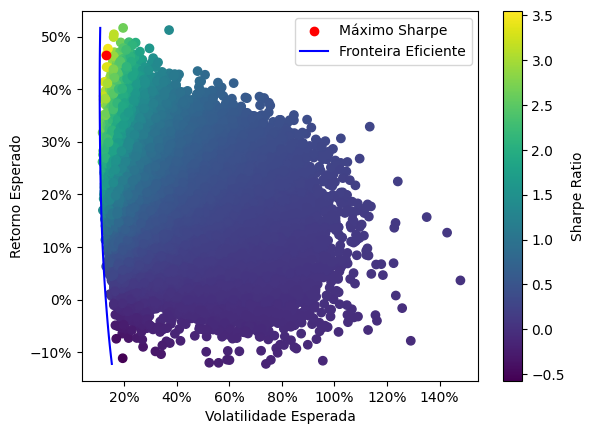

In [26]:
fig, ax = plt.subplots()

# Scatter plot dos dados
scatter = ax.scatter(tabela_volatilidade_esperadas, tabela_retornos_esperados, c=tabela_shape, cmap='viridis')
plt.xlabel('Volatilidade Esperada', color='black')  # Alterar cor do rótulo do eixo x
plt.ylabel('Retorno Esperado', color='black')  # Alterar cor do rótulo do eixo y

# Destacar o ponto com o maior Sharpe Ratio
ax.scatter(tabela_volatilidade_esperadas[indice_do_shaper_maximo], 
           tabela_retornos_esperados[indice_do_shaper_maximo], color='red', label='Máximo Sharpe')

# Plotar a fronteira eficiente
ax.plot(eixo_x_fronteira_eficiente, eixo_y_fronteira_eficiente, label='Fronteira Eficiente', color='blue')

# Formatar os eixos como porcentagem
ax.yaxis.set_major_formatter(mticker.PercentFormatter(1.0))
ax.xaxis.set_major_formatter(mticker.PercentFormatter(1.0))

# Alterar cores dos ticks
ax.tick_params(axis='x', colors='black')  # Alterar cor dos ticks do eixo x
ax.tick_params(axis='y', colors='black')  # Alterar cor dos ticks do eixo y

# Adicionar uma barra de cores para o scatter plot
cbar = plt.colorbar(scatter)
cbar.set_label('Sharpe Ratio', color='black')  # Alterar cor do rótulo da barra de cores
cbar.ax.yaxis.set_tick_params(color='black')  # Alterar cor dos ticks da barra de cores
plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='black')  # Alterar cor dos números da barra de cores

# Adicionar legenda
plt.legend()

# Exibir o gráfico
plt.show()

In [32]:
tickers

['PDGR3.SA',
 'B3SA3.SA',
 'COGN3.SA',
 'ABEV3.SA',
 'PETR4.SA',
 'BBDC4.SA',
 'FRAS3.SA',
 'MRFG3.SA',
 'ABCP11.SA',
 'ARNC34.SA']

Ticker      ABCP11.SA  ABEV3.SA  ARNC34.SA  B3SA3.SA  BBDC4.SA  COGN3.SA  \
Date                                                                       
2024-09-03  -0.006528 -0.005439  -0.012189 -0.022526  0.010845 -0.007353   
2024-09-04   0.002097  0.014844   0.000000  0.032922  0.007619  0.029630   
2024-09-05  -0.019671 -0.001540  -0.003587  0.003187  0.008822  0.014388   
2024-09-06   0.012950  0.001542   0.003996 -0.028594 -0.019363 -0.014184   
2024-09-09  -0.006041  0.009238   0.000000  0.005724  0.003185 -0.014388   

Ticker      FRAS3.SA  MRFG3.SA  PDGR3.SA  PETR4.SA  
Date                                                
2024-09-03  0.006144 -0.019369  0.000000 -0.012051  
2024-09-04  0.027990  0.074616 -0.062500  0.000260  
2024-09-05  0.000495 -0.007488  0.066667 -0.006227  
2024-09-06 -0.005443 -0.006859  0.000000 -0.019582  
2024-09-09 -0.014428 -0.008978  0.000000  0.010919  
Date
2024-09-03   -0.008840
2024-09-04    0.017687
2024-09-05   -0.006464
2024-09-06   -0.001957

/tmp/ipykernel_2237/2340622973.py:53: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  diferenca_final = float((retorno_acumulado_portfolio.iloc[-1] - retorno_acumulado_benchmark.iloc[-1]) * 100)


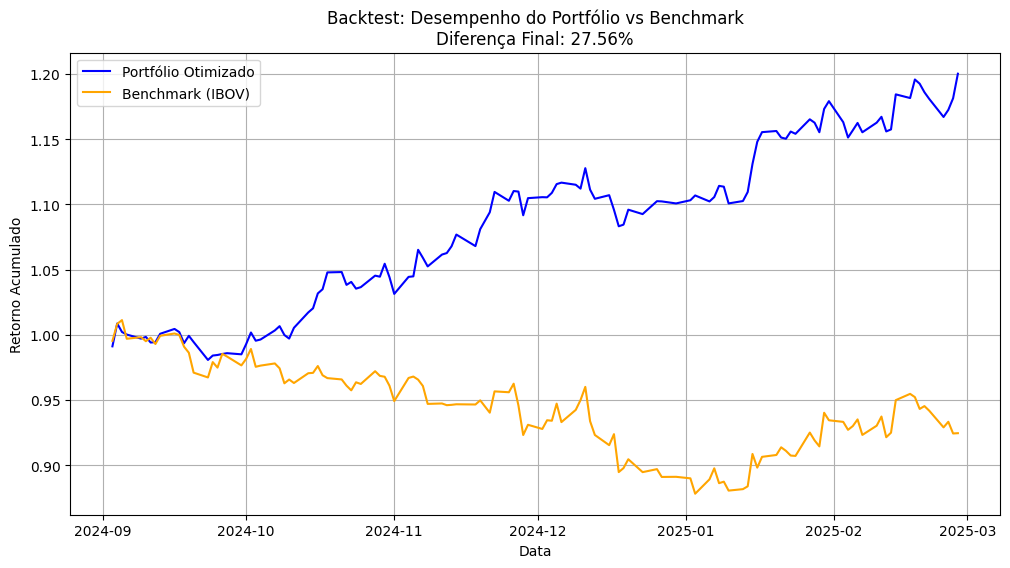

In [33]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Período de backtest
inicio_backtest = "2024-09-01"
fim_backtest = "2025-02-28"

# Pesos otimizados (exemplo: resultado da otimização)
pesos_otimizados = np.array([[0.28281761, 0.02262617, 0.23688409, 0.10337878, 0.06527728,
       0.00833955, 0.11012261, 0.12903958, 0.00176572, 0.03974863]])


tickers = ['PDGR3.SA',
 'B3SA3.SA',
 'COGN3.SA',
 'ABEV3.SA',
 'PETR4.SA',
 'BBDC4.SA',
 'FRAS3.SA',
 'MRFG3.SA',
 'ABCP11.SA',
 'ARNC34.SA']

# Baixar dados históricos para o período de backtest
dados_backtest = yf.download(tickers, start=inicio_backtest, end=fim_backtest, progress=False)['Close']

# Calcular retornos diários dos ativos
retornos_diarios = dados_backtest.pct_change().dropna()
print(retornos_diarios.head())

# Calcular o retorno diário do portfólio
retorno_portfolio = (retornos_diarios * pesos_otimizados).sum(axis=1)
print(retorno_portfolio.head())

# Baixar dados do benchmark (exemplo: IBOV)
benchmark = yf.download('^BVSP', start=inicio_backtest, end=fim_backtest, progress=False)['Close']
retorno_benchmark = benchmark.pct_change().dropna()
print(retorno_benchmark.head())

# Calcular o retorno acumulado
retorno_acumulado_portfolio = (1 + retorno_portfolio).cumprod()
retorno_acumulado_benchmark = (1 + retorno_benchmark).cumprod()
print(retorno_acumulado_portfolio.head())
print(retorno_acumulado_benchmark.head())

# Garantir alinhamento dos índices
retorno_acumulado_benchmark = retorno_acumulado_benchmark.reindex(retorno_acumulado_portfolio.index, method='ffill')
print(retorno_acumulado_benchmark.head())

# Calcular a diferença percentual final
diferenca_final = float((retorno_acumulado_portfolio.iloc[-1] - retorno_acumulado_benchmark.iloc[-1]) * 100)
print(f"Diferença percentual final: {diferenca_final:.2f}%")

# Adicionar ao título do gráfico


# Plotar o desempenho
plt.figure(figsize=(12, 6))
plt.plot(retorno_acumulado_portfolio, label="Portfólio Otimizado", color="blue")
plt.plot(retorno_acumulado_benchmark, label="Benchmark (IBOV)", color="orange")
plt.title(f"Backtest: Desempenho do Portfólio vs Benchmark\nDiferença Final: {diferenca_final:.2f}%")
plt.xlabel("Data")
plt.ylabel("Retorno Acumulado")
plt.legend()
plt.grid()
plt.show()

/tmp/ipykernel_2237/1925148206.py:54: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  diferenca_final_portfolio = float((retorno_acumulado_portfolio.iloc[-1] - retorno_acumulado_benchmark.iloc[-1]) * 100)


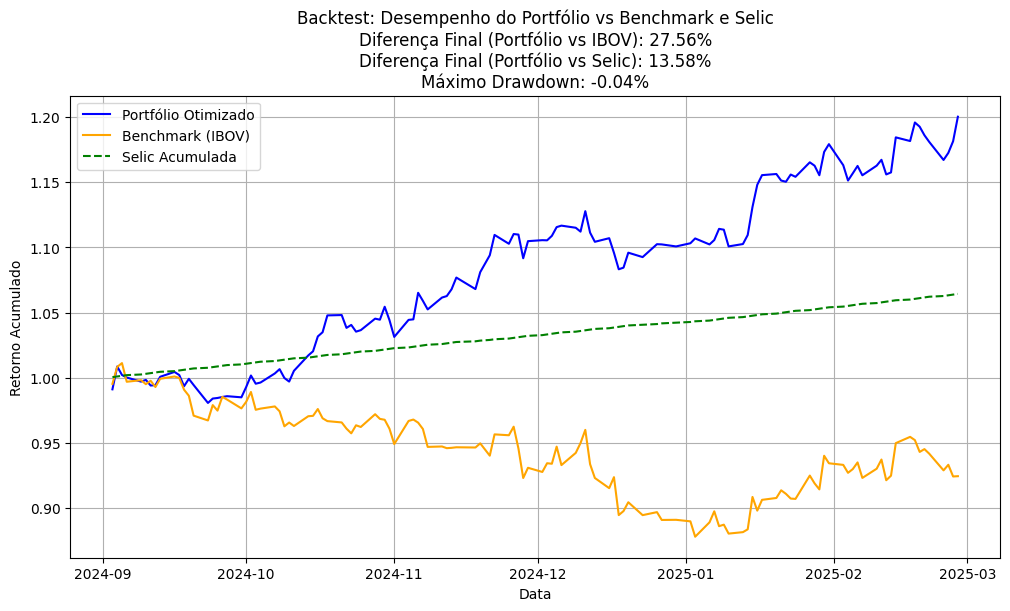

Diferença Final (Portfólio vs IBOV): 27.56%
Diferença Final (Portfólio vs Selic): 13.58%
Máximo Drawdown: -0.04%


In [34]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Período de backtest
inicio_backtest = "2024-09-01"
fim_backtest = "2025-02-28"

# Pesos otimizados (exemplo: resultado da otimização)
pesos_otimizados = np.array([[0.28281761, 0.02262617, 0.23688409, 0.10337878, 0.06527728,
       0.00833955, 0.11012261, 0.12903958, 0.00176572, 0.03974863]])

# Lista de tickers (exemplo)
tickers = ['PDGR3.SA',
 'B3SA3.SA',
 'COGN3.SA',
 'ABEV3.SA',
 'PETR4.SA',
 'BBDC4.SA',
 'FRAS3.SA',
 'MRFG3.SA',
 'ABCP11.SA',
 'ARNC34.SA']

# Baixar dados históricos para o período de backtest
dados_backtest = yf.download(tickers, start=inicio_backtest, end=fim_backtest, progress=False)['Close']

# Calcular retornos diários dos ativos
retornos_diarios = dados_backtest.pct_change().dropna()

# Calcular o retorno diário do portfólio
retorno_portfolio = (retornos_diarios * pesos_otimizados).sum(axis=1)

# Baixar dados do benchmark (exemplo: IBOV)
benchmark = yf.download('^BVSP', start=inicio_backtest, end=fim_backtest, progress=False)['Close']
retorno_benchmark = benchmark.pct_change().dropna()

# Calcular o retorno acumulado
retorno_acumulado_portfolio = (1 + retorno_portfolio).cumprod()
retorno_acumulado_benchmark = (1 + retorno_benchmark).cumprod()

# Garantir alinhamento dos índices
retorno_acumulado_benchmark = retorno_acumulado_benchmark.reindex(retorno_acumulado_portfolio.index, method='ffill')

# Obter dados históricos da Selic (exemplo: taxa anualizada em %)
selic_anual = 13.75 / 100  # Taxa anual em decimal
selic_diaria = (1 + selic_anual) ** (1 / 252) - 1  # Converter para taxa diária
datas = retorno_acumulado_portfolio.index
retorno_selic = pd.Series(selic_diaria, index=datas)
retorno_acumulado_selic = (1 + retorno_selic).cumprod()

# Calcular a diferença percentual final
diferenca_final_portfolio = float((retorno_acumulado_portfolio.iloc[-1] - retorno_acumulado_benchmark.iloc[-1]) * 100)
diferenca_final_selic = float((retorno_acumulado_portfolio.iloc[-1] - retorno_acumulado_selic.iloc[-1]) * 100)

# Análise de Drawdown (Máxima Perda)
peak = retorno_acumulado_portfolio.cummax()
drawdown = (retorno_acumulado_portfolio - peak) / peak
max_drawdown = drawdown.min()

# Plotar o desempenho
plt.figure(figsize=(12, 6))
plt.plot(retorno_acumulado_portfolio, label="Portfólio Otimizado", color="blue")
plt.plot(retorno_acumulado_benchmark, label="Benchmark (IBOV)", color="orange")
plt.plot(retorno_acumulado_selic, label="Selic Acumulada", color="green", linestyle="--")
plt.title(f"Backtest: Desempenho do Portfólio vs Benchmark e Selic\n"
          f"Diferença Final (Portfólio vs IBOV): {diferenca_final_portfolio:.2f}%\n"
          f"Diferença Final (Portfólio vs Selic): {diferenca_final_selic:.2f}%\n"
          f"Máximo Drawdown: {max_drawdown:.2f}%")
plt.xlabel("Data")
plt.ylabel("Retorno Acumulado")
plt.legend()
plt.grid()
plt.show()

# Exibir métricas
print(f"Diferença Final (Portfólio vs IBOV): {diferenca_final_portfolio:.2f}%")
print(f"Diferença Final (Portfólio vs Selic): {diferenca_final_selic:.2f}%")
print(f"Máximo Drawdown: {max_drawdown:.2f}%")

/home/codespace/anaconda3/envs/ds_env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/codespace/anaconda3/envs/ds_env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/codespace/anaconda3/envs/ds_env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/codespace/anaconda3/envs/ds_env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction resul

/home/codespace/anaconda3/envs/ds_env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/codespace/anaconda3/envs/ds_env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/codespace/anaconda3/envs/ds_env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/codespace/anaconda3/envs/ds_env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no asso

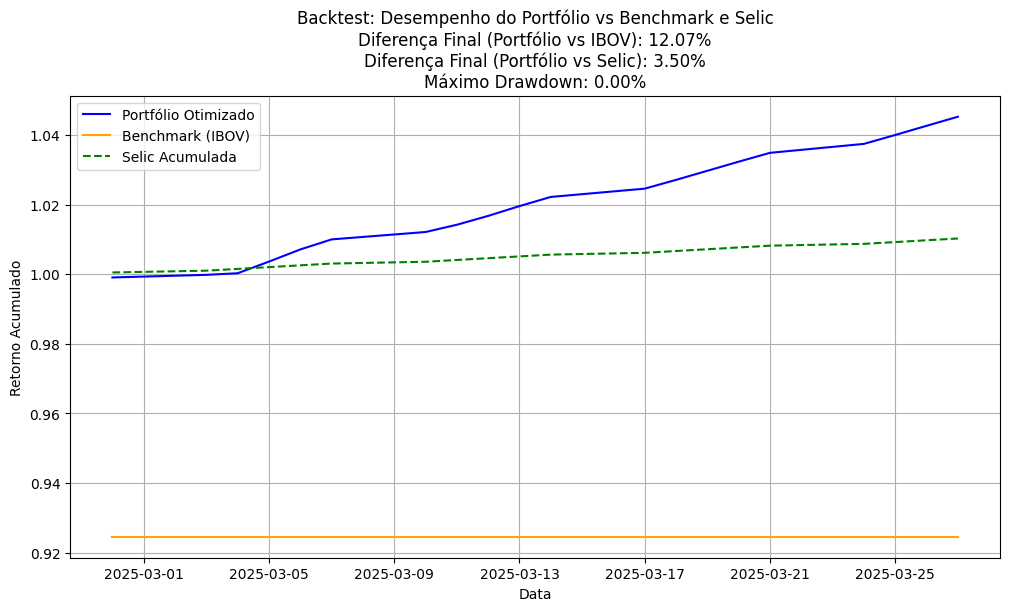

Diferença Final (Portfólio vs IBOV): 12.07%
Diferença Final (Portfólio vs Selic): 3.50%
Máximo Drawdown: 0.00%


In [36]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Período de backtest
inicio_backtest = "2024-09-01"
fim_backtest = "2025-02-28"

# Pesos otimizados (exemplo: resultado da otimização)
pesos_otimizados = np.array([0.28281761, 0.02262617, 0.23688409, 0.10337878, 0.06527728,
       0.00833955, 0.11012261, 0.12903958, 0.00176572, 0.03974863])

# Lista de tickers (exemplo)
tickers = ['PDGR3.SA',
 'B3SA3.SA',
 'COGN3.SA',
 'ABEV3.SA',
 'PETR4.SA',
 'BBDC4.SA',
 'FRAS3.SA',
 'MRFG3.SA',
 'ABCP11.SA',
 'ARNC34.SA']

# Baixar dados históricos para o período de backtest
dados_backtest = yf.download(tickers, start=inicio_backtest, end=fim_backtest, progress=False)['Close']

# Calcular retornos diários dos ativos
retornos_diarios = dados_backtest.pct_change().dropna()

# Número de dias para prever
dias_para_prever = 20

# Lista para armazenar as previsões
previsoes_ativos = []

# Prever os retornos para cada ativo
for ticker in tickers:
    # Dividir em treino e teste (últimos 20 dias para teste)
    retornos_ativo = retornos_diarios[ticker]
    treino = retornos_ativo
    
    # Ajuste do modelo ARIMA (usando p=5, d=1, q=0 como exemplo)
    modelo = ARIMA(treino, order=(5,1,0))
    modelo_ajustado = modelo.fit()
    
    # Previsão para os próximos 20 dias
    previsao = modelo_ajustado.forecast(steps=dias_para_prever)
    
    # Armazenar as previsões
    previsoes_ativos.append(previsao)

# Converter as previsões para um array numpy
previsoes_ativos = np.array(previsoes_ativos)

# Criar um índice de datas para as previsões (usando a última data de treinamento como base)
datas_previsao = pd.date_range(start=dados_backtest.index[-1] + pd.Timedelta(days=1), 
                                periods=dias_para_prever, freq='B')  # Frequência 'B' para dias úteis

# Criar uma série temporal para os retornos previstos do portfólio
retorno_portfolio_estimado = np.dot(pesos_otimizados, previsoes_ativos)  # Somando as previsões ponderadas pelos pesos
retorno_portfolio_estimado = pd.Series(retorno_portfolio_estimado, index=datas_previsao)

# Baixar dados do benchmark (exemplo: IBOV)
benchmark = yf.download('^BVSP', start=inicio_backtest, end=fim_backtest, progress=False)['Close']
retorno_benchmark = benchmark.pct_change().dropna()

# Calcular o retorno acumulado
retorno_acumulado_portfolio = (1 + retorno_portfolio_estimado).cumprod()
retorno_acumulado_benchmark = (1 + retorno_benchmark).cumprod()

# Garantir alinhamento dos índices
retorno_acumulado_benchmark = retorno_acumulado_benchmark.reindex(retorno_acumulado_portfolio.index, method='ffill')

# Obter dados históricos da Selic (exemplo: taxa anualizada em %)
selic_anual = 13.75 / 100  # Taxa anual em decimal
selic_diaria = (1 + selic_anual) ** (1 / 252) - 1  # Converter para taxa diária
datas = retorno_acumulado_portfolio.index
retorno_selic = pd.Series(selic_diaria, index=datas)
retorno_acumulado_selic = (1 + retorno_selic).cumprod()

# Calcular a diferença percentual final
diferenca_final_portfolio = float((retorno_acumulado_portfolio.iloc[-1] - retorno_acumulado_benchmark.iloc[-1]) * 100)
diferenca_final_selic = float((retorno_acumulado_portfolio.iloc[-1] - retorno_acumulado_selic.iloc[-1]) * 100)

# Análise de Drawdown (Máxima Perda)
peak = retorno_acumulado_portfolio.cummax()
drawdown = (retorno_acumulado_portfolio - peak) / peak
max_drawdown = drawdown.min()

# Plotar o desempenho
plt.figure(figsize=(12, 6))
plt.plot(retorno_acumulado_portfolio, label="Portfólio Otimizado", color="blue")
plt.plot(retorno_acumulado_benchmark, label="Benchmark (IBOV)", color="orange")
plt.plot(retorno_acumulado_selic, label="Selic Acumulada", color="green", linestyle="--")
plt.title(f"Backtest: Desempenho do Portfólio vs Benchmark e Selic\n"
          f"Diferença Final (Portfólio vs IBOV): {diferenca_final_portfolio:.2f}%\n"
          f"Diferença Final (Portfólio vs Selic): {diferenca_final_selic:.2f}%\n"
          f"Máximo Drawdown: {max_drawdown:.2f}%")
plt.xlabel("Data")
plt.ylabel("Retorno Acumulado")
plt.legend()
plt.grid()
plt.show()

# Exibir métricas
print(f"Diferença Final (Portfólio vs IBOV): {diferenca_final_portfolio:.2f}%")
print(f"Diferença Final (Portfólio vs Selic): {diferenca_final_selic:.2f}%")
print(f"Máximo Drawdown: {max_drawdown:.2f}%")

/home/codespace/anaconda3/envs/ds_env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/codespace/anaconda3/envs/ds_env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/codespace/anaconda3/envs/ds_env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/codespace/anaconda3/envs/ds_env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction resul

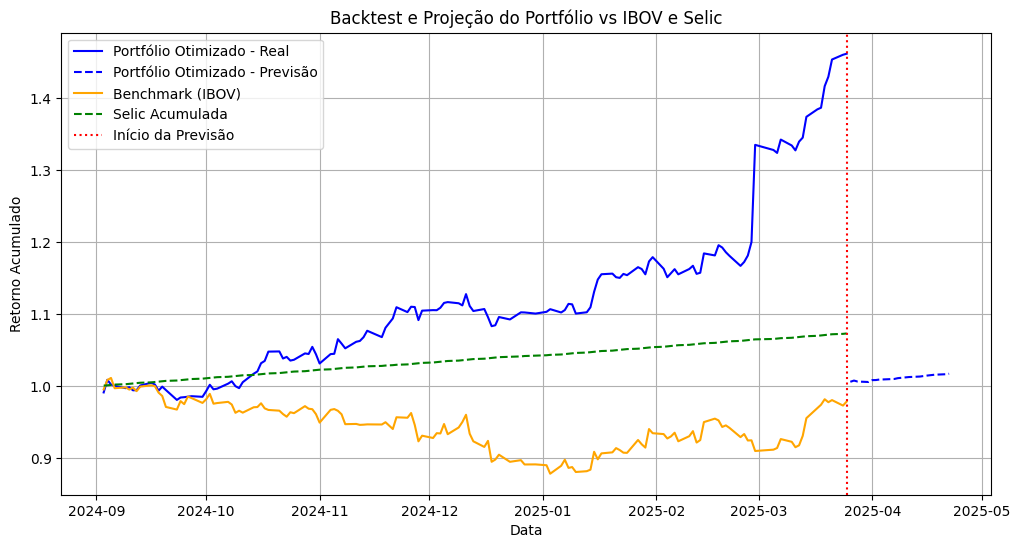

In [37]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Período de backtest
inicio_backtest = "2024-09-01"
fim_backtest = "2025-03-26"

# Pesos otimizados (exemplo: resultado da otimização)
pesos_otimizados = np.array([0.28281761, 0.02262617, 0.23688409, 0.10337878, 0.06527728,
       0.00833955, 0.11012261, 0.12903958, 0.00176572, 0.03974863])

# Lista de tickers (exemplo)
tickers = ['PDGR3.SA',
 'B3SA3.SA',
 'COGN3.SA',
 'ABEV3.SA',
 'PETR4.SA',
 'BBDC4.SA',
 'FRAS3.SA',
 'MRFG3.SA',
 'ABCP11.SA',
 'ARNC34.SA']

# Baixar dados históricos
dados_backtest = yf.download(tickers, start=inicio_backtest, end=fim_backtest, progress=False)['Close']

# Calcular retornos diários
retornos_diarios = dados_backtest.pct_change().dropna()

# Número de dias para prever
dias_para_prever = 20

# Previsões dos ativos usando ARIMA
previsoes_ativos = []
for ticker in tickers:
    retornos_ativo = retornos_diarios[ticker]
    modelo = ARIMA(retornos_ativo, order=(5,1,0))
    modelo_ajustado = modelo.fit()
    previsao = modelo_ajustado.forecast(steps=dias_para_prever)
    previsoes_ativos.append(previsao)

# Converter previsões para um array numpy
previsoes_ativos = np.array(previsoes_ativos)

# Criar índice de datas para previsões
datas_previsao = pd.date_range(start=dados_backtest.index[-1] + pd.Timedelta(days=1), 
                               periods=dias_para_prever, freq='B')

# Criar série temporal para os retornos previstos do portfólio
retorno_portfolio_estimado = np.dot(pesos_otimizados, previsoes_ativos)
retorno_portfolio_estimado = pd.Series(retorno_portfolio_estimado, index=datas_previsao)

# Baixar dados do benchmark (IBOV)
benchmark = yf.download('^BVSP', start=inicio_backtest, end=fim_backtest, progress=False)['Close']
retorno_benchmark = benchmark.pct_change().dropna()

# Calcular retornos acumulados
retorno_acumulado_portfolio_real = (1 + retornos_diarios.dot(pesos_otimizados)).cumprod()
retorno_acumulado_portfolio_previsto = (1 + retorno_portfolio_estimado).cumprod()
retorno_acumulado_benchmark = (1 + retorno_benchmark).cumprod()

# Garantir alinhamento dos índices
retorno_acumulado_benchmark = retorno_acumulado_benchmark.reindex(retorno_acumulado_portfolio_real.index, method='ffill')

# Obter taxa Selic diária e calcular retorno acumulado
selic_anual = 13.75 / 100  
selic_diaria = (1 + selic_anual) ** (1 / 252) - 1
retorno_selic = pd.Series(selic_diaria, index=retorno_acumulado_portfolio_real.index)
retorno_acumulado_selic = (1 + retorno_selic).cumprod()

# Concatenar real + previsão do portfólio
retorno_acumulado_portfolio = pd.concat([retorno_acumulado_portfolio_real, retorno_acumulado_portfolio_previsto])

# Criar um DataFrame único para facilitar o alinhamento das datas
df_resultado = pd.DataFrame({
    "Portfólio Real": retorno_acumulado_portfolio_real,
    "Portfólio Previsto": retorno_acumulado_portfolio_previsto,
})

# Concatenar sem perder a sequência temporal
df_resultado = df_resultado.reindex(df_resultado.index.union(datas_previsao))

# Preencher os valores futuros do portfólio real com NaN para evitar distorção
df_resultado.loc[datas_previsao, "Portfólio Real"] = np.nan

# Gráfico
plt.figure(figsize=(12, 6))
plt.plot(df_resultado.index, df_resultado["Portfólio Real"], label="Portfólio Otimizado - Real", color="blue")
plt.plot(df_resultado.index, df_resultado["Portfólio Previsto"], label="Portfólio Otimizado - Previsão", color="blue", linestyle="dashed")
plt.plot(retorno_acumulado_benchmark, label="Benchmark (IBOV)", color="orange")
plt.plot(retorno_acumulado_selic, label="Selic Acumulada", color="green", linestyle="--")

# Adicionar linha vertical indicando o ponto de transição
plt.axvline(x=retorno_acumulado_portfolio_real.index[-1], color='red', linestyle='dotted', label="Início da Previsão")

plt.title("Backtest e Projeção do Portfólio vs IBOV e Selic")
plt.xlabel("Data")
plt.ylabel("Retorno Acumulado")
plt.legend()
plt.grid()
plt.show()

/home/codespace/anaconda3/envs/ds_env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/codespace/anaconda3/envs/ds_env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/codespace/anaconda3/envs/ds_env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/codespace/anaconda3/envs/ds_env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction resul

/home/codespace/anaconda3/envs/ds_env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/codespace/anaconda3/envs/ds_env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/codespace/anaconda3/envs/ds_env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/codespace/anaconda3/envs/ds_env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no asso

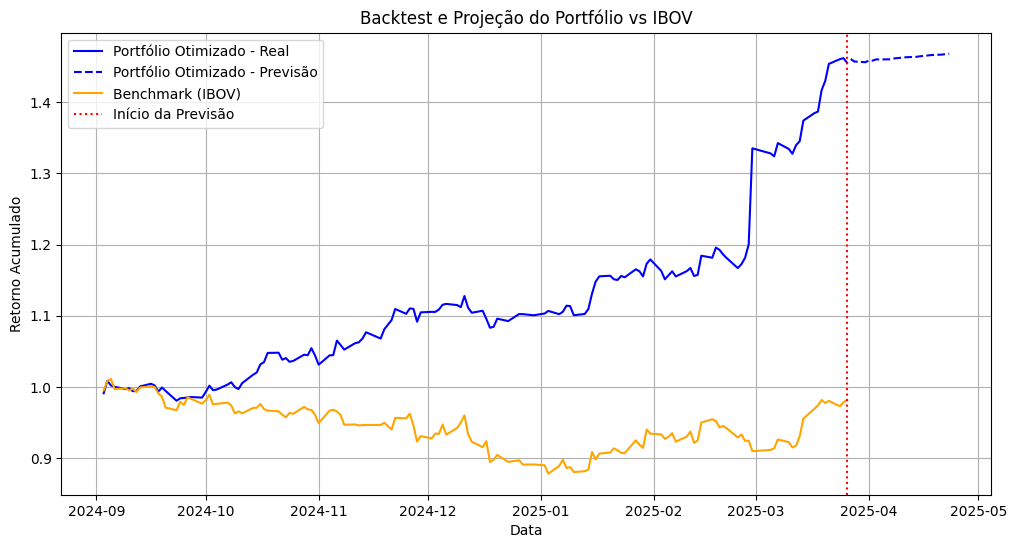

In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Período de backtest
inicio_backtest = "2024-09-01"
fim_backtest = "2025-03-27"

# Pesos otimizados (exemplo: resultado da otimização)
pesos_otimizados = np.array([0.28281761, 0.02262617, 0.23688409, 0.10337878, 0.06527728,
       0.00833955, 0.11012261, 0.12903958, 0.00176572, 0.03974863])

# Lista de tickers (exemplo)
tickers = ['PDGR3.SA',
 'B3SA3.SA',
 'COGN3.SA',
 'ABEV3.SA',
 'PETR4.SA',
 'BBDC4.SA',
 'FRAS3.SA',
 'MRFG3.SA',
 'ABCP11.SA',
 'ARNC34.SA']

# Baixar dados históricos
dados_backtest = yf.download(tickers, start=inicio_backtest, end=fim_backtest, progress=False)['Close']

# Calcular retornos diários
retornos_diarios = dados_backtest.pct_change().dropna()

# Número de dias para prever
dias_para_prever = 20

# Previsões dos ativos usando ARIMA
previsoes_ativos = []
for ticker in tickers:
    retornos_ativo = retornos_diarios[ticker]
    modelo = ARIMA(retornos_ativo, order=(5,1,0))
    modelo_ajustado = modelo.fit()
    previsao = modelo_ajustado.forecast(steps=dias_para_prever)
    previsoes_ativos.append(previsao)

# Converter previsões para um array numpy
previsoes_ativos = np.array(previsoes_ativos)

# Criar índice de datas para previsões
datas_previsao = pd.date_range(start=dados_backtest.index[-1] + pd.Timedelta(days=1), 
                               periods=dias_para_prever, freq='B')

# Criar série temporal para os retornos previstos do portfólio
retorno_portfolio_estimado = np.dot(pesos_otimizados, previsoes_ativos)
retorno_portfolio_estimado = pd.Series(retorno_portfolio_estimado, index=datas_previsao)

# Baixar dados do benchmark (IBOV)
benchmark = yf.download('^BVSP', start=inicio_backtest, end=fim_backtest, progress=False)['Close']
retorno_benchmark = benchmark.pct_change().dropna()

# Calcular retornos acumulados
retorno_acumulado_portfolio_real = (1 + retornos_diarios.dot(pesos_otimizados)).cumprod()

# **Correção: ajustar a previsão para começar do último valor real**
ultimo_valor_real = retorno_acumulado_portfolio_real.iloc[-1]
retorno_acumulado_portfolio_previsto = (1 + retorno_portfolio_estimado).cumprod() * ultimo_valor_real

# Calcular retorno acumulado do IBOV
retorno_acumulado_benchmark = (1 + retorno_benchmark).cumprod()

# Garantir alinhamento dos índices
retorno_acumulado_benchmark = retorno_acumulado_benchmark.reindex(retorno_acumulado_portfolio_real.index, method='ffill')

# Obter taxa Selic diária e calcular retorno acumulado
selic_anual = 13.75 / 100  
selic_diaria = (1 + selic_anual) ** (1 / 252) - 1
retorno_selic = pd.Series(selic_diaria, index=retorno_acumulado_portfolio_real.index)
retorno_acumulado_selic = (1 + retorno_selic).cumprod()

# **Correção: Concatenação correta das séries real e prevista**
retorno_acumulado_portfolio = pd.concat([retorno_acumulado_portfolio_real, retorno_acumulado_portfolio_previsto])

# Gráfico
plt.figure(figsize=(12, 6))
plt.plot(retorno_acumulado_portfolio_real, label="Portfólio Otimizado - Real", color="blue")
plt.plot(retorno_acumulado_portfolio_previsto, label="Portfólio Otimizado - Previsão", color="blue", linestyle="dashed")
plt.plot(retorno_acumulado_benchmark, label="Benchmark (IBOV)", color="orange")
#plt.plot(retorno_acumulado_selic, label="Selic Acumulada", color="green", linestyle="--")

# Adicionar linha vertical indicando o ponto de transição
plt.axvline(x=retorno_acumulado_portfolio_real.index[-1], color='red', linestyle='dotted', label="Início da Previsão")

plt.title("Backtest e Projeção do Portfólio vs IBOV")
plt.xlabel("Data")
plt.ylabel("Retorno Acumulado")
plt.legend()
plt.grid()
plt.show()

# Olha o ação que teve um pico

In [59]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA

# Parâmetros do backtest
INICIO_BACKTEST = "2024-09-01"
FIM_BACKTEST = "2025-03-26"
DIAS_PREVISAO = 20

# Pesos otimizados para o portfólio (normalizados)
PESOS_OTIMIZADOS = np.array([3.51419949e-01, 1.16111017e-02, 1.39947727e-01, 6.02933016e-02,
                              2.66916447e-02, 2.41629080e-04, 3.10265841e-01, 8.61439633e-02,
                              7.30613929e-03, 6.07870449e-03])
PESOS_OTIMIZADOS /= PESOS_OTIMIZADOS.sum()  # Normalização

# Lista de tickers dos ativos
TICKERS = ["ABCP11.SA", "ABEV3.SA", "ARNC34.SA", "B3SA3.SA", "BBDC4.SA", 
           "COGN3.SA", "FRAS3.SA", "MRFG3.SA", "PDGR3.SA", "PETR4.SA"]

def obter_dados(tickers, inicio, fim):
    """Baixa dados históricos de fechamento ajustado."""
    return yf.download(tickers, start=inicio, end=fim, progress=False)['Close']

def calcular_retornos(dados):
    """Calcula os retornos diários dos ativos."""
    return dados.pct_change().dropna()

def prever_retornos_arima(retornos_diarios, dias_prev):
    """Realiza previsões de retornos diários usando ARIMA."""
    previsoes = []
    for ticker in retornos_diarios.columns:
        try:
            modelo_auto = auto_arima(retornos_diarios[ticker], seasonal=False, stepwise=True, suppress_warnings=True)
            modelo_ajustado = modelo_auto.fit(retornos_diarios[ticker])
            previsao = modelo_ajustado.predict(n_periods=dias_prev)
            previsoes.append(previsao)
        except Exception as e:
            print(f"Erro ao ajustar ARIMA para {ticker}: {e}")
            previsoes.append(np.zeros(dias_prev))  # Caso de falha, assume retorno zero
    return np.array(previsoes)

# Obter dados e calcular retornos
dados_backtest = obter_dados(TICKERS, INICIO_BACKTEST, FIM_BACKTEST)
retornos_diarios = calcular_retornos(dados_backtest)

# Fazer previsões
previsoes_ativos = prever_retornos_arima(retornos_diarios, DIAS_PREVISAO)

# Criar índice de datas para previsões
datas_previsao = pd.date_range(start=dados_backtest.index[-1], periods=DIAS_PREVISAO, freq='B')

# Estimar retorno do portfólio
retorno_portfolio_estimado = np.dot(PESOS_OTIMIZADOS, previsoes_ativos)
retorno_portfolio_estimado = pd.Series(retorno_portfolio_estimado, index=datas_previsao)

# Baixar dados do benchmark (IBOV)
benchmark = obter_dados('^BVSP', INICIO_BACKTEST, FIM_BACKTEST)
retorno_benchmark = calcular_retornos(benchmark)

# Retorno acumulado do portfólio real
retorno_acumulado_portfolio_real = (1 + retornos_diarios.dot(PESOS_OTIMIZADOS)).cumprod()

# Ajustar previsão para começar do último valor real
ultimo_valor_real = retorno_acumulado_portfolio_real.iloc[-1]
retorno_acumulado_portfolio_previsto = (1 + retorno_portfolio_estimado).cumprod() * ultimo_valor_real

# Retorno acumulado do IBOV
retorno_acumulado_benchmark = (1 + retorno_benchmark).cumprod()
retorno_acumulado_benchmark = retorno_acumulado_benchmark.reindex(retorno_acumulado_portfolio_real.index, method='ffill')

# Calcular retorno da Selic
selic_anual = 13.75 / 100  
selic_diaria = (1 + selic_anual) ** (1 / 252) - 1
retorno_selic = pd.Series(selic_diaria, index=retorno_acumulado_portfolio_real.index)
retorno_acumulado_selic = (1 + retorno_selic).cumprod() - 1  # Ajuste para não superestimar

# Concatenar dados reais e previstos
retorno_acumulado_portfolio = pd.concat([retorno_acumulado_portfolio_real, retorno_acumulado_portfolio_previsto])

# Plotagem dos resultados
plt.figure(figsize=(12, 6))
plt.plot(retorno_acumulado_portfolio_real, label="Portfólio - Real", color="blue")
plt.plot(retorno_acumulado_portfolio_previsto, label="Portfólio - Previsão", color="blue", linestyle="dashed")
plt.plot(retorno_acumulado_benchmark, label="IBOV", color="orange")
plt.plot(retorno_acumulado_selic, label="Selic", color="green")

# Adicionar linha indicando o início da previsão
plt.axvline(x=retorno_acumulado_portfolio_real.index[-1], color='red', linestyle='dotted', label="Início da Previsão")

plt.title("Backtest e Previsão do Portfólio vs IBOV e Selic")
plt.xlabel("Data")
plt.ylabel("Retorno Acumulado")
plt.legend()
plt.grid()
plt.show()

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

#### Bask Test

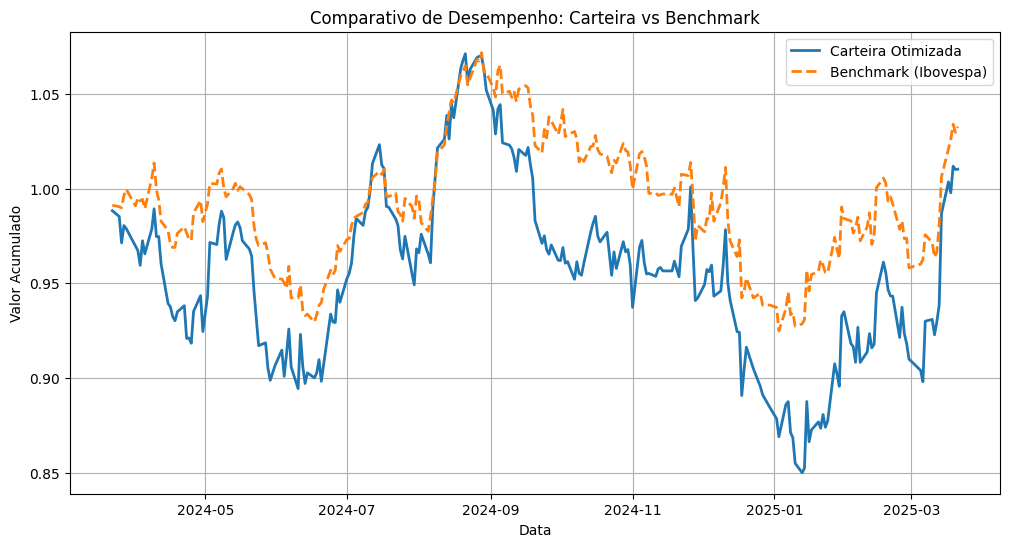

In [9]:
# Função para rodar o backtest
def rodar_backtest(precos, pesos):
    # Calcular os retornos diários dos ativos
    retornos_diarios = precos.pct_change().dropna()
    
    # Calcular os retornos diários da carteira
    retornos_carteira = (retornos_diarios * pesos).sum(axis=1)
    
    # Calcular o valor acumulado da carteira
    valor_acumulado = (1 + retornos_carteira).cumprod()
    
    return valor_acumulado

# Obter os preços históricos dos ativos
precos_historicos = yf.download(tickers, period="1y", group_by="ticker", progress=False)
precos = pd.DataFrame({ticker: precos_historicos[ticker]['Close'] for ticker in tickers if ticker in precos_historicos.columns})

# Rodar o backtest com os pesos da melhor carteira
pesos_melhor_carteira = melhor_carteira['Pesos']  # Já definido anteriormente
resultado_backtest = rodar_backtest(precos, pesos_melhor_carteira)

# Obter os preços históricos do benchmark (ex.: Ibovespa)
benchmark_ticker = "^BVSP"  # Substitua pelo índice desejado
benchmark_precos = yf.download(benchmark_ticker, period="1y", progress=False)['Close']
benchmark_retorno_acumulado = (1 + benchmark_precos.pct_change().dropna()).cumprod()

# Plotar o desempenho acumulado da carteira e do benchmark
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(resultado_backtest, label="Carteira Otimizada", linewidth=2)
plt.plot(benchmark_retorno_acumulado, label="Benchmark (Ibovespa)", linewidth=2, linestyle="--")
plt.title("Comparativo de Desempenho: Carteira vs Benchmark")
plt.xlabel("Data")
plt.ylabel("Valor Acumulado")
plt.legend()
plt.grid()
plt.show()

#### lixo